In [31]:
from __future__ import absolute_import, division, print_function, unicode_literals
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

# On Mac you may encounter an error related to OMP, this is a workaround, but slows down the code
# https://github.com/dmlc/xgboost/issues/1715
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ['CUDA_HOME'] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.3"
os.environ['CUDA_VERSION'] = "11.3"

In [32]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'2.9.3'

In [33]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [34]:
if tf.test.gpu_device_name():
    print("Default GPU Device:{}".format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF if you have one.")

Default GPU Device:/device:GPU:0


In [35]:
from openbot import dataloader, data_augmentation, utils, train

## Set train and test dirs

Define the dataset directory and give it a name. Inside the dataset folder, there should be two folders, `train_data` and `test_data`. 

In [36]:
dataset_dir = "dataset"
dataset_name = "openbot"
train_data_dir = os.path.join(dataset_dir, "train_data")
test_data_dir = os.path.join(dataset_dir, "test_data")

## Hyperparameters
<a id='hyperparameters'></a>

You may have to tune the learning rate and batch size depending on your available compute resources and dataset. As a general rule of thumb, if you increase the batch size by a factor of n, you can increase the learning rate by a factor of sqrt(n). In order to accelerate training and make it more smooth, you should increase the batch size as much as possible. In our paper we used a batch size of 128. For debugging and hyperparamter tuning, you can set the number of epochs to a small value like 10. If you want to train a model which will achieve good performance, you should set it to 50 or more. In our paper we used 100.

In [37]:
params = train.Hyperparameters()

params.MODEL = "pilot_net"  # choices: "pilot_net","cil_mobile","cil_mobile_fast","cil"
params.POLICY = "autopilot"  # choices: "autopilot","point_goal_nav"
params.TRAIN_BATCH_SIZE = 16
params.TEST_BATCH_SIZE = 16
params.LEARNING_RATE = 0.0003
params.NUM_EPOCHS = 100
params.BATCH_NORM = True  # use batch norm (recommended)
params.FLIP_AUG = False  # flip image and controls as augmentation (only autopilot)
params.CMD_AUG = False  # randomize high-level command as augmentation (only autopilot)
params.USE_LAST = False  # resume training from last checkpoint
params.WANDB = False
# policy = "autopilot": images are expected to be 256x96 - no cropping required
# policy = "point_goal_nav": images are expected to be 160x120 - cropping to 160x90
params.IS_CROP = params.POLICY == "point_goal_nav"

## Pre-process the dataset

In [38]:
tr = train.Training(params)
tr.dataset_name = dataset_name
tr.train_data_dir = train_data_dir
tr.test_data_dir = test_data_dir

Running this for the first time will take some time. This code will match image frames to the controls (labels) and indicator signals (commands).  By default, data samples where the vehicle was stationary will be removed. If this is not desired, you need to set `tr.remove_zeros = False`. If you have made any changes to the sensor files, changed `remove_zeros` or moved your dataset to a new directory, you need to set `tr.redo_matching = True`. 

In [39]:
tr.redo_matching = False
tr.remove_zeros = True
train.process_data(tr)

Train Datasets:  1
Test Datasets:  1
Processing folder dataset\train_data\dataset_control\20231019_103930
 Frames and controls already matched.
 Frames and commands already matched.
 Preprocessing already completed.
Processing folder dataset\train_data\dataset_control\20231019_104104
 Frames and controls already matched.
 Frames and commands already matched.
 Preprocessing already completed.
Processing folder dataset\test_data\my_dataset_2\20231019_104030
 Frames and controls already matched.
 Frames and commands already matched.
 Preprocessing already completed.
Processing folder dataset\test_data\my_dataset_2\20231019_104140
 Frames and controls already matched.
 Frames and commands already matched.
 Preprocessing already completed.
There are 675 train images and 385 test images


In [40]:
import threading


def broadcast(event, payload=None):
    print(event, payload)


event = threading.Event()
my_callback = train.MyCallback(broadcast, event)

In the next step, you can convert your dataset to a tfrecord, a data format optimized for training. You can skip this step if you already created a tfrecord before or if you want to train using the files directly. 

In [41]:
train.create_tfrecord(my_callback, policy=tr.hyperparameters.POLICY)

message Converting data to tfrecord (this may take some time)...
Reading dataset from c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\train_data
TFRecord will be saved at c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\tfrecords/train.tfrec
Number of Datasets Available:  1
Processing folder c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\train_data\dataset_control\20231019_103930
 Frames and controls matched.
 Frames and high-level commands matched.
 Removed timestamp: 1043678141250172
 Removed timestamp: 1043681233839286
 Removed timestamp: 1043681298937202
 Removed timestamp: 1043681373785484
 Removed timestamp: 1043681673419754
 Removed timestamp: 1043681807869077
 Removed timestamp: 1043681905809858
 Removed timestamp: 1043681982484181
 Removed timestamp: 1043696899452353
 Removed timestamp: 1043696985515582
 Removed timestamp: 1043697077757040
 Removed timestamp: 1043697162742925
 Removed timestamp: 1043697243723290
 Removed timestamp: 1043697333473707
 Remove

TFRecord file created successfully.
Reading dataset from c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\test_data
TFRecord will be saved at c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\tfrecords/test.tfrec
Number of Datasets Available:  1
Processing folder c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\test_data\my_dataset_2\20231019_104030
 Frames and controls matched.
 Frames and high-level commands matched.
 Preprocessing completed.
Processing folder c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\test_data\my_dataset_2\20231019_104140
 Frames and controls matched.
 Frames and high-level commands matched.
 Preprocessing completed.
1043731532550516,c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\test_data\my_dataset_2\20231019_104030\images\1550_crop.jpeg,-40,128,0
1043731629591089,c:\Users\lilou\Documents\Master\OpenBot\policy\dataset\test_data\my_dataset_2\20231019_104030\images\1551_crop.jpeg,-40,128,0
1043731710977027,c:\Users\lilou\Documen

## Load the dataset

If you did not create a tfrecord and want to load and buffer files from disk directly, set `no_tf_record = True`.

In [42]:
no_tf_record = True

In [43]:
if no_tf_record:
    tr.train_data_dir = train_data_dir
    tr.test_data_dir = test_data_dir
    train.load_data(tr, verbose=0)
else:
    tr.train_data_dir = os.path.join(dataset_dir, "tfrecords/train.tfrec")
    tr.test_data_dir = os.path.join(dataset_dir, "tfrecords/test.tfrec")
    train.load_tfrecord(tr, verbose=0)

Number of train samples: 675
Number of test samples: 385
Image shape:  (300, 300, 3)
Command:  0.0
Label:  [0.39607844 0.39607844]


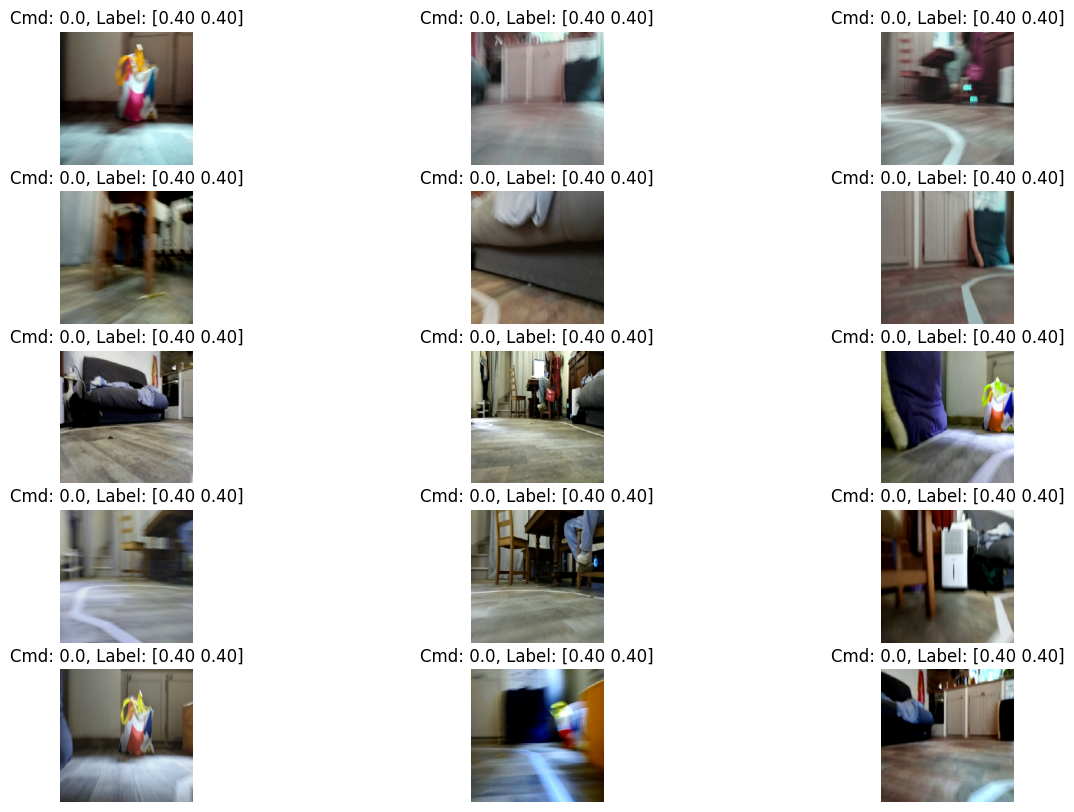

In [44]:
utils.show_batch(dataset=tr.train_ds, policy=tr.hyperparameters.POLICY, model=None)

## Training

The number of epochs is proportional to the training time. One epoch means going through the complete dataset once. Increasing `NUM_EPOCHS` will mean longer training time, but generally leads to better performance. To get familiar with the code it can be set to small values like `5` or `10`. To train a model that performs well, it should be set to values between `50` and `200`. Setting `USE_LAST` to `true` will resume the training from the last checkpoint. The default values are `NUM_EPOCHS = 100` and `USE_LAST = False`. They are set in [Hyperparameters](#hyperparameters).

In [45]:
# params.NUM_EPOCHS = 200
# params.USE_LAST = True

train.do_training(tr, my_callback, verbose=0)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
model openbot_pilot_net_lr0.0003_bz16_bn
message Fit model...


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 0.002587687224149704, 'mean_absolute_error': 0.4456123113632202, 'direction_metric': 0.15843023359775543, 'angle_metric': 0.15843023359775543, 'val_loss': 1.9622963009169325e-05, 'val_mean_absolute_error': 0.04360894486308098, 'val_direction_metric': 0.8996913433074951, 'val_angle_metric': 0.8996913433074951, 'epoch': 0}
logs {'loss': 0.002587687224149704, 'mean_absolute_error': 0.4456123113632202, 'direction_metric': 0.15843023359775543, 'angle_metric': 0.15843023359775543, 'val_loss': 1.9622963009169325e-05, 'val_mean_absolute_error': 0.04360894486308098, 'val_direction_metric': 0.8996913433074951, 'val_angle_metric': 0.8996913433074951, 'epoch': 0}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.0008250301470980048, 'mean_absolute_error': 0.3045908808708191, 'direction_metric': 0.29505813121795654, 'angle_metric': 0.29505813121795654, 'val_loss': 0.00036386577994562685, 'val_mean_absolute_error': 0.2772769629955292, 'val_direction_metric': 0.0, 'val_angle_metric': 0.0, 'epoch': 1}
logs {'loss': 0.0008250301470980048, 'mean_absolute_error': 0.3045908808708191, 'direction_metric': 0.29505813121795654, 'angle_metric': 0.29505813121795654, 'val_loss': 0.00036386577994562685, 'val_mean_absolute_error': 0.2772769629955292, 'val_direction_metric': 0.0, 'val_angle_metric': 0.0, 'epoch': 1}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.00042952236253768206, 'mean_absolute_error': 0.2574887275695801, 'direction_metric': 0.43023255467414856, 'angle_metric': 0.43023255467414856, 'val_loss': 0.00043040886521339417, 'val_mean_absolute_error': 0.33416280150413513, 'val_direction_metric': 0.013888888992369175, 'val_angle_metric': 0.013888888992369175, 'epoch': 2}
logs {'loss': 0.00042952236253768206, 'mean_absolute_error': 0.2574887275695801, 'direction_metric': 0.43023255467414856, 'angle_metric': 0.43023255467414856, 'val_loss': 0.00043040886521339417, 'val_mean_absolute_error': 0.33416280150413513, 'val_direction_metric': 0.013888888992369175, 'val_angle_metric': 0.013888888992369175, 'epoch': 2}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.00032902913517318666, 'mean_absolute_error': 0.21893364191055298, 'direction_metric': 0.4985465109348297, 'angle_metric': 0.4985465109348297, 'val_loss': 0.0003922607284039259, 'val_mean_absolute_error': 0.3778632879257202, 'val_direction_metric': 0.5787037014961243, 'val_angle_metric': 0.5787037014961243, 'epoch': 3}
logs {'loss': 0.00032902913517318666, 'mean_absolute_error': 0.21893364191055298, 'direction_metric': 0.4985465109348297, 'angle_metric': 0.4985465109348297, 'val_loss': 0.0003922607284039259, 'val_mean_absolute_error': 0.3778632879257202, 'val_direction_metric': 0.5787037014961243, 'val_angle_metric': 0.5787037014961243, 'epoch': 3}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.0002441731048747897, 'mean_absolute_error': 0.19222509860992432, 'direction_metric': 0.5261628031730652, 'angle_metric': 0.5261628031730652, 'val_loss': 0.00046895197010599077, 'val_mean_absolute_error': 0.279928594827652, 'val_direction_metric': 0.004629629664123058, 'val_angle_metric': 0.004629629664123058, 'epoch': 4}
logs {'loss': 0.0002441731048747897, 'mean_absolute_error': 0.19222509860992432, 'direction_metric': 0.5261628031730652, 'angle_metric': 0.5261628031730652, 'val_loss': 0.00046895197010599077, 'val_mean_absolute_error': 0.279928594827652, 'val_direction_metric': 0.004629629664123058, 'val_angle_metric': 0.004629629664123058, 'epoch': 4}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.00021415652008727193, 'mean_absolute_error': 0.16516362130641937, 'direction_metric': 0.5348837375640869, 'angle_metric': 0.5348837375640869, 'val_loss': 0.00010193331399932504, 'val_mean_absolute_error': 0.17702358961105347, 'val_direction_metric': 0.8487654328346252, 'val_angle_metric': 0.8487654328346252, 'epoch': 5}
logs {'loss': 0.00021415652008727193, 'mean_absolute_error': 0.16516362130641937, 'direction_metric': 0.5348837375640869, 'angle_metric': 0.5348837375640869, 'val_loss': 0.00010193331399932504, 'val_mean_absolute_error': 0.17702358961105347, 'val_direction_metric': 0.8487654328346252, 'val_angle_metric': 0.8487654328346252, 'epoch': 5}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.00015306074055843055, 'mean_absolute_error': 0.141789972782135, 'direction_metric': 0.5857558250427246, 'angle_metric': 0.5857558250427246, 'val_loss': 0.00010967504931613803, 'val_mean_absolute_error': 0.14076325297355652, 'val_direction_metric': 0.4367283880710602, 'val_angle_metric': 0.4367283880710602, 'epoch': 6}
logs {'loss': 0.00015306074055843055, 'mean_absolute_error': 0.141789972782135, 'direction_metric': 0.5857558250427246, 'angle_metric': 0.5857558250427246, 'val_loss': 0.00010967504931613803, 'val_mean_absolute_error': 0.14076325297355652, 'val_direction_metric': 0.4367283880710602, 'val_angle_metric': 0.4367283880710602, 'epoch': 6}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 0.0001218053002958186, 'mean_absolute_error': 0.12278532236814499, 'direction_metric': 0.6235465407371521, 'angle_metric': 0.6235465407371521, 'val_loss': 4.342708780313842e-05, 'val_mean_absolute_error': 0.08092246949672699, 'val_direction_metric': 0.7685185074806213, 'val_angle_metric': 0.7685185074806213, 'epoch': 7}
logs {'loss': 0.0001218053002958186, 'mean_absolute_error': 0.12278532236814499, 'direction_metric': 0.6235465407371521, 'angle_metric': 0.6235465407371521, 'val_loss': 4.342708780313842e-05, 'val_mean_absolute_error': 0.08092246949672699, 'val_direction_metric': 0.7685185074806213, 'val_angle_metric': 0.7685185074806213, 'epoch': 7}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 9.969246457330883e-05, 'mean_absolute_error': 0.11053191870450974, 'direction_metric': 0.6511628031730652, 'angle_metric': 0.6511628031730652, 'val_loss': 3.249312430853024e-05, 'val_mean_absolute_error': 0.060370080173015594, 'val_direction_metric': 0.8487654328346252, 'val_angle_metric': 0.8487654328346252, 'epoch': 8}
logs {'loss': 9.969246457330883e-05, 'mean_absolute_error': 0.11053191870450974, 'direction_metric': 0.6511628031730652, 'angle_metric': 0.6511628031730652, 'val_loss': 3.249312430853024e-05, 'val_mean_absolute_error': 0.060370080173015594, 'val_direction_metric': 0.8487654328346252, 'val_angle_metric': 0.8487654328346252, 'epoch': 8}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 8.824362157611176e-05, 'mean_absolute_error': 0.10457209497690201, 'direction_metric': 0.6758720874786377, 'angle_metric': 0.6758720874786377, 'val_loss': 5.2137966122245416e-05, 'val_mean_absolute_error': 0.08224286139011383, 'val_direction_metric': 0.7253086566925049, 'val_angle_metric': 0.7253086566925049, 'epoch': 9}
logs {'loss': 8.824362157611176e-05, 'mean_absolute_error': 0.10457209497690201, 'direction_metric': 0.6758720874786377, 'angle_metric': 0.6758720874786377, 'val_loss': 5.2137966122245416e-05, 'val_mean_absolute_error': 0.08224286139011383, 'val_direction_metric': 0.7253086566925049, 'val_angle_metric': 0.7253086566925049, 'epoch': 9}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 7.010465196799487e-05, 'mean_absolute_error': 0.0962614044547081, 'direction_metric': 0.7180232405662537, 'angle_metric': 0.7180232405662537, 'val_loss': 0.00010832984116859734, 'val_mean_absolute_error': 0.11725351214408875, 'val_direction_metric': 0.44907405972480774, 'val_angle_metric': 0.44907405972480774, 'epoch': 10}
logs {'loss': 7.010465196799487e-05, 'mean_absolute_error': 0.0962614044547081, 'direction_metric': 0.7180232405662537, 'angle_metric': 0.7180232405662537, 'val_loss': 0.00010832984116859734, 'val_mean_absolute_error': 0.11725351214408875, 'val_direction_metric': 0.44907405972480774, 'val_angle_metric': 0.44907405972480774, 'epoch': 10}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 6.47931155981496e-05, 'mean_absolute_error': 0.08729608356952667, 'direction_metric': 0.7267441749572754, 'angle_metric': 0.7267441749572754, 'val_loss': 9.503675391897559e-05, 'val_mean_absolute_error': 0.11236277967691422, 'val_direction_metric': 0.48765432834625244, 'val_angle_metric': 0.48765432834625244, 'epoch': 11}
logs {'loss': 6.47931155981496e-05, 'mean_absolute_error': 0.08729608356952667, 'direction_metric': 0.7267441749572754, 'angle_metric': 0.7267441749572754, 'val_loss': 9.503675391897559e-05, 'val_mean_absolute_error': 0.11236277967691422, 'val_direction_metric': 0.48765432834625244, 'val_angle_metric': 0.48765432834625244, 'epoch': 11}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 5.2435480029089376e-05, 'mean_absolute_error': 0.07867604494094849, 'direction_metric': 0.729651153087616, 'angle_metric': 0.729651153087616, 'val_loss': 7.53310596337542e-05, 'val_mean_absolute_error': 0.10127857327461243, 'val_direction_metric': 0.6311728358268738, 'val_angle_metric': 0.6311728358268738, 'epoch': 12}
logs {'loss': 5.2435480029089376e-05, 'mean_absolute_error': 0.07867604494094849, 'direction_metric': 0.729651153087616, 'angle_metric': 0.729651153087616, 'val_loss': 7.53310596337542e-05, 'val_mean_absolute_error': 0.10127857327461243, 'val_direction_metric': 0.6311728358268738, 'val_angle_metric': 0.6311728358268738, 'epoch': 12}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 5.062621858087368e-05, 'mean_absolute_error': 0.07681801915168762, 'direction_metric': 0.7601743936538696, 'angle_metric': 0.7601743936538696, 'val_loss': 6.264560943236575e-05, 'val_mean_absolute_error': 0.0915357694029808, 'val_direction_metric': 0.7345678806304932, 'val_angle_metric': 0.7345678806304932, 'epoch': 13}
logs {'loss': 5.062621858087368e-05, 'mean_absolute_error': 0.07681801915168762, 'direction_metric': 0.7601743936538696, 'angle_metric': 0.7601743936538696, 'val_loss': 6.264560943236575e-05, 'val_mean_absolute_error': 0.0915357694029808, 'val_direction_metric': 0.7345678806304932, 'val_angle_metric': 0.7345678806304932, 'epoch': 13}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 4.971200542058796e-05, 'mean_absolute_error': 0.08004755526781082, 'direction_metric': 0.7790697813034058, 'angle_metric': 0.7790697813034058, 'val_loss': 5.244537169346586e-05, 'val_mean_absolute_error': 0.09244555234909058, 'val_direction_metric': 0.7839506268501282, 'val_angle_metric': 0.7839506268501282, 'epoch': 14}
logs {'loss': 4.971200542058796e-05, 'mean_absolute_error': 0.08004755526781082, 'direction_metric': 0.7790697813034058, 'angle_metric': 0.7790697813034058, 'val_loss': 5.244537169346586e-05, 'val_mean_absolute_error': 0.09244555234909058, 'val_direction_metric': 0.7839506268501282, 'val_angle_metric': 0.7839506268501282, 'epoch': 14}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 4.898738916381262e-05, 'mean_absolute_error': 0.07444236427545547, 'direction_metric': 0.8212209343910217, 'angle_metric': 0.8212209343910217, 'val_loss': 4.959035140927881e-05, 'val_mean_absolute_error': 0.08771415054798126, 'val_direction_metric': 0.7746913433074951, 'val_angle_metric': 0.7746913433074951, 'epoch': 15}
logs {'loss': 4.898738916381262e-05, 'mean_absolute_error': 0.07444236427545547, 'direction_metric': 0.8212209343910217, 'angle_metric': 0.8212209343910217, 'val_loss': 4.959035140927881e-05, 'val_mean_absolute_error': 0.08771415054798126, 'val_direction_metric': 0.7746913433074951, 'val_angle_metric': 0.7746913433074951, 'epoch': 15}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 3.493520125630312e-05, 'mean_absolute_error': 0.0665917843580246, 'direction_metric': 0.8110465407371521, 'angle_metric': 0.8110465407371521, 'val_loss': 4.5673474232899025e-05, 'val_mean_absolute_error': 0.08061573654413223, 'val_direction_metric': 0.7947530746459961, 'val_angle_metric': 0.7947530746459961, 'epoch': 16}
logs {'loss': 3.493520125630312e-05, 'mean_absolute_error': 0.0665917843580246, 'direction_metric': 0.8110465407371521, 'angle_metric': 0.8110465407371521, 'val_loss': 4.5673474232899025e-05, 'val_mean_absolute_error': 0.08061573654413223, 'val_direction_metric': 0.7947530746459961, 'val_angle_metric': 0.7947530746459961, 'epoch': 16}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 3.6741079384228215e-05, 'mean_absolute_error': 0.06553135067224503, 'direction_metric': 0.832848846912384, 'angle_metric': 0.832848846912384, 'val_loss': 4.345830893726088e-05, 'val_mean_absolute_error': 0.08637446910142899, 'val_direction_metric': 0.8333333134651184, 'val_angle_metric': 0.8333333134651184, 'epoch': 17}
logs {'loss': 3.6741079384228215e-05, 'mean_absolute_error': 0.06553135067224503, 'direction_metric': 0.832848846912384, 'angle_metric': 0.832848846912384, 'val_loss': 4.345830893726088e-05, 'val_mean_absolute_error': 0.08637446910142899, 'val_direction_metric': 0.8333333134651184, 'val_angle_metric': 0.8333333134651184, 'epoch': 17}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 3.272694448241964e-05, 'mean_absolute_error': 0.06660610437393188, 'direction_metric': 0.8619186282157898, 'angle_metric': 0.8619186282157898, 'val_loss': 3.5366265365155414e-05, 'val_mean_absolute_error': 0.08296259492635727, 'val_direction_metric': 0.8703703880310059, 'val_angle_metric': 0.8703703880310059, 'epoch': 18}
logs {'loss': 3.272694448241964e-05, 'mean_absolute_error': 0.06660610437393188, 'direction_metric': 0.8619186282157898, 'angle_metric': 0.8619186282157898, 'val_loss': 3.5366265365155414e-05, 'val_mean_absolute_error': 0.08296259492635727, 'val_direction_metric': 0.8703703880310059, 'val_angle_metric': 0.8703703880310059, 'epoch': 18}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 3.081862087128684e-05, 'mean_absolute_error': 0.06372680515050888, 'direction_metric': 0.8386628031730652, 'angle_metric': 0.8386628031730652, 'val_loss': 2.858788866433315e-05, 'val_mean_absolute_error': 0.07336413115262985, 'val_direction_metric': 0.9089506268501282, 'val_angle_metric': 0.9089506268501282, 'epoch': 19}
logs {'loss': 3.081862087128684e-05, 'mean_absolute_error': 0.06372680515050888, 'direction_metric': 0.8386628031730652, 'angle_metric': 0.8386628031730652, 'val_loss': 2.858788866433315e-05, 'val_mean_absolute_error': 0.07336413115262985, 'val_direction_metric': 0.9089506268501282, 'val_angle_metric': 0.9089506268501282, 'epoch': 19}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 2.6761072149383835e-05, 'mean_absolute_error': 0.06268312782049179, 'direction_metric': 0.854651153087616, 'angle_metric': 0.854651153087616, 'val_loss': 3.1682084227213636e-05, 'val_mean_absolute_error': 0.0813218429684639, 'val_direction_metric': 0.8919752836227417, 'val_angle_metric': 0.8919752836227417, 'epoch': 20}
logs {'loss': 2.6761072149383835e-05, 'mean_absolute_error': 0.06268312782049179, 'direction_metric': 0.854651153087616, 'angle_metric': 0.854651153087616, 'val_loss': 3.1682084227213636e-05, 'val_mean_absolute_error': 0.0813218429684639, 'val_direction_metric': 0.8919752836227417, 'val_angle_metric': 0.8919752836227417, 'epoch': 20}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 2.3262658942257985e-05, 'mean_absolute_error': 0.055005356669425964, 'direction_metric': 0.882267415523529, 'angle_metric': 0.882267415523529, 'val_loss': 3.0972110835136846e-05, 'val_mean_absolute_error': 0.07684971392154694, 'val_direction_metric': 0.8703703880310059, 'val_angle_metric': 0.8703703880310059, 'epoch': 21}
logs {'loss': 2.3262658942257985e-05, 'mean_absolute_error': 0.055005356669425964, 'direction_metric': 0.882267415523529, 'angle_metric': 0.882267415523529, 'val_loss': 3.0972110835136846e-05, 'val_mean_absolute_error': 0.07684971392154694, 'val_direction_metric': 0.8703703880310059, 'val_angle_metric': 0.8703703880310059, 'epoch': 21}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 2.628347101563122e-05, 'mean_absolute_error': 0.05956004559993744, 'direction_metric': 0.875, 'angle_metric': 0.875, 'val_loss': 2.6520634492044337e-05, 'val_mean_absolute_error': 0.07582026720046997, 'val_direction_metric': 0.9259259104728699, 'val_angle_metric': 0.9259259104728699, 'epoch': 22}
logs {'loss': 2.628347101563122e-05, 'mean_absolute_error': 0.05956004559993744, 'direction_metric': 0.875, 'angle_metric': 0.875, 'val_loss': 2.6520634492044337e-05, 'val_mean_absolute_error': 0.07582026720046997, 'val_direction_metric': 0.9259259104728699, 'val_angle_metric': 0.9259259104728699, 'epoch': 22}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 2.2009304302628152e-05, 'mean_absolute_error': 0.05309928208589554, 'direction_metric': 0.9098837375640869, 'angle_metric': 0.9098837375640869, 'val_loss': 2.8469163225963712e-05, 'val_mean_absolute_error': 0.0785117819905281, 'val_direction_metric': 0.9135802388191223, 'val_angle_metric': 0.9135802388191223, 'epoch': 23}
logs {'loss': 2.2009304302628152e-05, 'mean_absolute_error': 0.05309928208589554, 'direction_metric': 0.9098837375640869, 'angle_metric': 0.9098837375640869, 'val_loss': 2.8469163225963712e-05, 'val_mean_absolute_error': 0.0785117819905281, 'val_direction_metric': 0.9135802388191223, 'val_angle_metric': 0.9135802388191223, 'epoch': 23}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 2.0785757442354225e-05, 'mean_absolute_error': 0.05319037660956383, 'direction_metric': 0.895348846912384, 'angle_metric': 0.895348846912384, 'val_loss': 2.3450746084563434e-05, 'val_mean_absolute_error': 0.0730295181274414, 'val_direction_metric': 0.9398148059844971, 'val_angle_metric': 0.9398148059844971, 'epoch': 24}
logs {'loss': 2.0785757442354225e-05, 'mean_absolute_error': 0.05319037660956383, 'direction_metric': 0.895348846912384, 'angle_metric': 0.895348846912384, 'val_loss': 2.3450746084563434e-05, 'val_mean_absolute_error': 0.0730295181274414, 'val_direction_metric': 0.9398148059844971, 'val_angle_metric': 0.9398148059844971, 'epoch': 24}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 2.000877975660842e-05, 'mean_absolute_error': 0.05287374556064606, 'direction_metric': 0.9026162624359131, 'angle_metric': 0.9026162624359131, 'val_loss': 2.700197546801064e-05, 'val_mean_absolute_error': 0.07920027524232864, 'val_direction_metric': 0.9413580298423767, 'val_angle_metric': 0.9413580298423767, 'epoch': 25}
logs {'loss': 2.000877975660842e-05, 'mean_absolute_error': 0.05287374556064606, 'direction_metric': 0.9026162624359131, 'angle_metric': 0.9026162624359131, 'val_loss': 2.700197546801064e-05, 'val_mean_absolute_error': 0.07920027524232864, 'val_direction_metric': 0.9413580298423767, 'val_angle_metric': 0.9413580298423767, 'epoch': 25}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 1.8445687601342797e-05, 'mean_absolute_error': 0.05086536332964897, 'direction_metric': 0.9186046719551086, 'angle_metric': 0.9186046719551086, 'val_loss': 2.2719803382642567e-05, 'val_mean_absolute_error': 0.0703408420085907, 'val_direction_metric': 0.9413580298423767, 'val_angle_metric': 0.9413580298423767, 'epoch': 26}
logs {'loss': 1.8445687601342797e-05, 'mean_absolute_error': 0.05086536332964897, 'direction_metric': 0.9186046719551086, 'angle_metric': 0.9186046719551086, 'val_loss': 2.2719803382642567e-05, 'val_mean_absolute_error': 0.0703408420085907, 'val_direction_metric': 0.9413580298423767, 'val_angle_metric': 0.9413580298423767, 'epoch': 26}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 1.6590704035479575e-05, 'mean_absolute_error': 0.047335486859083176, 'direction_metric': 0.9229651093482971, 'angle_metric': 0.9229651093482971, 'val_loss': 2.4291703084600158e-05, 'val_mean_absolute_error': 0.07724428921937943, 'val_direction_metric': 0.9583333134651184, 'val_angle_metric': 0.9583333134651184, 'epoch': 27}
logs {'loss': 1.6590704035479575e-05, 'mean_absolute_error': 0.047335486859083176, 'direction_metric': 0.9229651093482971, 'angle_metric': 0.9229651093482971, 'val_loss': 2.4291703084600158e-05, 'val_mean_absolute_error': 0.07724428921937943, 'val_direction_metric': 0.9583333134651184, 'val_angle_metric': 0.9583333134651184, 'epoch': 27}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 1.4589894817618188e-05, 'mean_absolute_error': 0.04668951407074928, 'direction_metric': 0.9433139562606812, 'angle_metric': 0.9433139562606812, 'val_loss': 2.4501887310179882e-05, 'val_mean_absolute_error': 0.07986154407262802, 'val_direction_metric': 0.9552469253540039, 'val_angle_metric': 0.9552469253540039, 'epoch': 28}
logs {'loss': 1.4589894817618188e-05, 'mean_absolute_error': 0.04668951407074928, 'direction_metric': 0.9433139562606812, 'angle_metric': 0.9433139562606812, 'val_loss': 2.4501887310179882e-05, 'val_mean_absolute_error': 0.07986154407262802, 'val_direction_metric': 0.9552469253540039, 'val_angle_metric': 0.9552469253540039, 'epoch': 28}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 1.7364995073876344e-05, 'mean_absolute_error': 0.04826241359114647, 'direction_metric': 0.9098837375640869, 'angle_metric': 0.9098837375640869, 'val_loss': 2.513996332709212e-05, 'val_mean_absolute_error': 0.07969347387552261, 'val_direction_metric': 0.9444444179534912, 'val_angle_metric': 0.9444444179534912, 'epoch': 29}
logs {'loss': 1.7364995073876344e-05, 'mean_absolute_error': 0.04826241359114647, 'direction_metric': 0.9098837375640869, 'angle_metric': 0.9098837375640869, 'val_loss': 2.513996332709212e-05, 'val_mean_absolute_error': 0.07969347387552261, 'val_direction_metric': 0.9444444179534912, 'val_angle_metric': 0.9444444179534912, 'epoch': 29}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 1.5700969015597366e-05, 'mean_absolute_error': 0.04828822985291481, 'direction_metric': 0.9244186282157898, 'angle_metric': 0.9244186282157898, 'val_loss': 2.175579356844537e-05, 'val_mean_absolute_error': 0.075960174202919, 'val_direction_metric': 0.9660493731498718, 'val_angle_metric': 0.9660493731498718, 'epoch': 30}
logs {'loss': 1.5700969015597366e-05, 'mean_absolute_error': 0.04828822985291481, 'direction_metric': 0.9244186282157898, 'angle_metric': 0.9244186282157898, 'val_loss': 2.175579356844537e-05, 'val_mean_absolute_error': 0.075960174202919, 'val_direction_metric': 0.9660493731498718, 'val_angle_metric': 0.9660493731498718, 'epoch': 30}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 1.2547106962301768e-05, 'mean_absolute_error': 0.04173911735415459, 'direction_metric': 0.9287790656089783, 'angle_metric': 0.9287790656089783, 'val_loss': 2.5277089662267826e-05, 'val_mean_absolute_error': 0.08246637135744095, 'val_direction_metric': 0.9413580298423767, 'val_angle_metric': 0.9413580298423767, 'epoch': 31}
logs {'loss': 1.2547106962301768e-05, 'mean_absolute_error': 0.04173911735415459, 'direction_metric': 0.9287790656089783, 'angle_metric': 0.9287790656089783, 'val_loss': 2.5277089662267826e-05, 'val_mean_absolute_error': 0.08246637135744095, 'val_direction_metric': 0.9413580298423767, 'val_angle_metric': 0.9413580298423767, 'epoch': 31}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 1.3285106433613691e-05, 'mean_absolute_error': 0.045774079859256744, 'direction_metric': 0.9389534592628479, 'angle_metric': 0.9389534592628479, 'val_loss': 2.2724068912793882e-05, 'val_mean_absolute_error': 0.07724197208881378, 'val_direction_metric': 0.959876537322998, 'val_angle_metric': 0.959876537322998, 'epoch': 32}
logs {'loss': 1.3285106433613691e-05, 'mean_absolute_error': 0.045774079859256744, 'direction_metric': 0.9389534592628479, 'angle_metric': 0.9389534592628479, 'val_loss': 2.2724068912793882e-05, 'val_mean_absolute_error': 0.07724197208881378, 'val_direction_metric': 0.959876537322998, 'val_angle_metric': 0.959876537322998, 'epoch': 32}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 1.2076378880010452e-05, 'mean_absolute_error': 0.04289765655994415, 'direction_metric': 0.9534883499145508, 'angle_metric': 0.9534883499145508, 'val_loss': 2.21219816012308e-05, 'val_mean_absolute_error': 0.07918039709329605, 'val_direction_metric': 0.9783950448036194, 'val_angle_metric': 0.9783950448036194, 'epoch': 33}
logs {'loss': 1.2076378880010452e-05, 'mean_absolute_error': 0.04289765655994415, 'direction_metric': 0.9534883499145508, 'angle_metric': 0.9534883499145508, 'val_loss': 2.21219816012308e-05, 'val_mean_absolute_error': 0.07918039709329605, 'val_direction_metric': 0.9783950448036194, 'val_angle_metric': 0.9783950448036194, 'epoch': 33}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 1.2558208254631609e-05, 'mean_absolute_error': 0.043141987174749374, 'direction_metric': 0.9476743936538696, 'angle_metric': 0.9476743936538696, 'val_loss': 2.384024628554471e-05, 'val_mean_absolute_error': 0.07934077829122543, 'val_direction_metric': 0.9506173133850098, 'val_angle_metric': 0.9506173133850098, 'epoch': 34}
logs {'loss': 1.2558208254631609e-05, 'mean_absolute_error': 0.043141987174749374, 'direction_metric': 0.9476743936538696, 'angle_metric': 0.9476743936538696, 'val_loss': 2.384024628554471e-05, 'val_mean_absolute_error': 0.07934077829122543, 'val_direction_metric': 0.9506173133850098, 'val_angle_metric': 0.9506173133850098, 'epoch': 34}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 1.032064847095171e-05, 'mean_absolute_error': 0.0372612327337265, 'direction_metric': 0.9680232405662537, 'angle_metric': 0.9680232405662537, 'val_loss': 2.274713733640965e-05, 'val_mean_absolute_error': 0.0807294100522995, 'val_direction_metric': 0.9768518805503845, 'val_angle_metric': 0.9768518805503845, 'epoch': 35}
logs {'loss': 1.032064847095171e-05, 'mean_absolute_error': 0.0372612327337265, 'direction_metric': 0.9680232405662537, 'angle_metric': 0.9680232405662537, 'val_loss': 2.274713733640965e-05, 'val_mean_absolute_error': 0.0807294100522995, 'val_direction_metric': 0.9768518805503845, 'val_angle_metric': 0.9768518805503845, 'epoch': 35}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 1.2104937923140824e-05, 'mean_absolute_error': 0.0417497344315052, 'direction_metric': 0.9563953280448914, 'angle_metric': 0.9563953280448914, 'val_loss': 2.3212411178974435e-05, 'val_mean_absolute_error': 0.08009311556816101, 'val_direction_metric': 0.9737654328346252, 'val_angle_metric': 0.9737654328346252, 'epoch': 36}
logs {'loss': 1.2104937923140824e-05, 'mean_absolute_error': 0.0417497344315052, 'direction_metric': 0.9563953280448914, 'angle_metric': 0.9563953280448914, 'val_loss': 2.3212411178974435e-05, 'val_mean_absolute_error': 0.08009311556816101, 'val_direction_metric': 0.9737654328346252, 'val_angle_metric': 0.9737654328346252, 'epoch': 36}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 1.0546930752752814e-05, 'mean_absolute_error': 0.04124704748392105, 'direction_metric': 0.9636628031730652, 'angle_metric': 0.9636628031730652, 'val_loss': 2.3605674869031645e-05, 'val_mean_absolute_error': 0.08021710813045502, 'val_direction_metric': 0.970678985118866, 'val_angle_metric': 0.970678985118866, 'epoch': 37}
logs {'loss': 1.0546930752752814e-05, 'mean_absolute_error': 0.04124704748392105, 'direction_metric': 0.9636628031730652, 'angle_metric': 0.9636628031730652, 'val_loss': 2.3605674869031645e-05, 'val_mean_absolute_error': 0.08021710813045502, 'val_direction_metric': 0.970678985118866, 'val_angle_metric': 0.970678985118866, 'epoch': 37}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 9.44022394833155e-06, 'mean_absolute_error': 0.036697015166282654, 'direction_metric': 0.9593023061752319, 'angle_metric': 0.9593023061752319, 'val_loss': 2.196389323216863e-05, 'val_mean_absolute_error': 0.07752267271280289, 'val_direction_metric': 0.9675925970077515, 'val_angle_metric': 0.9675925970077515, 'epoch': 38}
logs {'loss': 9.44022394833155e-06, 'mean_absolute_error': 0.036697015166282654, 'direction_metric': 0.9593023061752319, 'angle_metric': 0.9593023061752319, 'val_loss': 2.196389323216863e-05, 'val_mean_absolute_error': 0.07752267271280289, 'val_direction_metric': 0.9675925970077515, 'val_angle_metric': 0.9675925970077515, 'epoch': 38}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 9.597188181942329e-06, 'mean_absolute_error': 0.03766615316271782, 'direction_metric': 0.9607558250427246, 'angle_metric': 0.9607558250427246, 'val_loss': 2.3308859454118647e-05, 'val_mean_absolute_error': 0.08136007189750671, 'val_direction_metric': 0.9675925970077515, 'val_angle_metric': 0.9675925970077515, 'epoch': 39}
logs {'loss': 9.597188181942329e-06, 'mean_absolute_error': 0.03766615316271782, 'direction_metric': 0.9607558250427246, 'angle_metric': 0.9607558250427246, 'val_loss': 2.3308859454118647e-05, 'val_mean_absolute_error': 0.08136007189750671, 'val_direction_metric': 0.9675925970077515, 'val_angle_metric': 0.9675925970077515, 'epoch': 39}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 7.392495263047749e-06, 'mean_absolute_error': 0.034320782870054245, 'direction_metric': 0.9840116500854492, 'angle_metric': 0.9840116500854492, 'val_loss': 2.020964166149497e-05, 'val_mean_absolute_error': 0.07562906295061111, 'val_direction_metric': 0.9675925970077515, 'val_angle_metric': 0.9675925970077515, 'epoch': 40}
logs {'loss': 7.392495263047749e-06, 'mean_absolute_error': 0.034320782870054245, 'direction_metric': 0.9840116500854492, 'angle_metric': 0.9840116500854492, 'val_loss': 2.020964166149497e-05, 'val_mean_absolute_error': 0.07562906295061111, 'val_direction_metric': 0.9675925970077515, 'val_angle_metric': 0.9675925970077515, 'epoch': 40}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 8.063188033702318e-06, 'mean_absolute_error': 0.03623233363032341, 'direction_metric': 0.9781976938247681, 'angle_metric': 0.9781976938247681, 'val_loss': 1.8460968931321986e-05, 'val_mean_absolute_error': 0.07440754026174545, 'val_direction_metric': 0.9922839403152466, 'val_angle_metric': 0.9922839403152466, 'epoch': 41}
logs {'loss': 8.063188033702318e-06, 'mean_absolute_error': 0.03623233363032341, 'direction_metric': 0.9781976938247681, 'angle_metric': 0.9781976938247681, 'val_loss': 1.8460968931321986e-05, 'val_mean_absolute_error': 0.07440754026174545, 'val_direction_metric': 0.9922839403152466, 'val_angle_metric': 0.9922839403152466, 'epoch': 41}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 1.0811297215695959e-05, 'mean_absolute_error': 0.0405142642557621, 'direction_metric': 0.9622092843055725, 'angle_metric': 0.9622092843055725, 'val_loss': 2.121984289260581e-05, 'val_mean_absolute_error': 0.0789664015173912, 'val_direction_metric': 0.9830247163772583, 'val_angle_metric': 0.9830247163772583, 'epoch': 42}
logs {'loss': 1.0811297215695959e-05, 'mean_absolute_error': 0.0405142642557621, 'direction_metric': 0.9622092843055725, 'angle_metric': 0.9622092843055725, 'val_loss': 2.121984289260581e-05, 'val_mean_absolute_error': 0.0789664015173912, 'val_direction_metric': 0.9830247163772583, 'val_angle_metric': 0.9830247163772583, 'epoch': 42}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 9.885959116218146e-06, 'mean_absolute_error': 0.04057544469833374, 'direction_metric': 0.9694767594337463, 'angle_metric': 0.9694767594337463, 'val_loss': 2.0062047042301856e-05, 'val_mean_absolute_error': 0.07860638201236725, 'val_direction_metric': 0.9907407164573669, 'val_angle_metric': 0.9907407164573669, 'epoch': 43}
logs {'loss': 9.885959116218146e-06, 'mean_absolute_error': 0.04057544469833374, 'direction_metric': 0.9694767594337463, 'angle_metric': 0.9694767594337463, 'val_loss': 2.0062047042301856e-05, 'val_mean_absolute_error': 0.07860638201236725, 'val_direction_metric': 0.9907407164573669, 'val_angle_metric': 0.9907407164573669, 'epoch': 43}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 8.719805009604897e-06, 'mean_absolute_error': 0.037112828344106674, 'direction_metric': 0.9767441749572754, 'angle_metric': 0.9767441749572754, 'val_loss': 2.1366371584008448e-05, 'val_mean_absolute_error': 0.08047790825366974, 'val_direction_metric': 0.9814814925193787, 'val_angle_metric': 0.9814814925193787, 'epoch': 44}
logs {'loss': 8.719805009604897e-06, 'mean_absolute_error': 0.037112828344106674, 'direction_metric': 0.9767441749572754, 'angle_metric': 0.9767441749572754, 'val_loss': 2.1366371584008448e-05, 'val_mean_absolute_error': 0.08047790825366974, 'val_direction_metric': 0.9814814925193787, 'val_angle_metric': 0.9814814925193787, 'epoch': 44}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 6.725089860992739e-06, 'mean_absolute_error': 0.03225203603506088, 'direction_metric': 0.9781976938247681, 'angle_metric': 0.9781976938247681, 'val_loss': 2.0511040929704905e-05, 'val_mean_absolute_error': 0.08069662749767303, 'val_direction_metric': 0.9953703880310059, 'val_angle_metric': 0.9953703880310059, 'epoch': 45}
logs {'loss': 6.725089860992739e-06, 'mean_absolute_error': 0.03225203603506088, 'direction_metric': 0.9781976938247681, 'angle_metric': 0.9781976938247681, 'val_loss': 2.0511040929704905e-05, 'val_mean_absolute_error': 0.08069662749767303, 'val_direction_metric': 0.9953703880310059, 'val_angle_metric': 0.9953703880310059, 'epoch': 45}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 7.825786269677337e-06, 'mean_absolute_error': 0.03619169443845749, 'direction_metric': 0.979651153087616, 'angle_metric': 0.979651153087616, 'val_loss': 2.306156966369599e-05, 'val_mean_absolute_error': 0.08664131164550781, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 46}
logs {'loss': 7.825786269677337e-06, 'mean_absolute_error': 0.03619169443845749, 'direction_metric': 0.979651153087616, 'angle_metric': 0.979651153087616, 'val_loss': 2.306156966369599e-05, 'val_mean_absolute_error': 0.08664131164550781, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 46}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 7.265362000907771e-06, 'mean_absolute_error': 0.03491883724927902, 'direction_metric': 0.9840116500854492, 'angle_metric': 0.9840116500854492, 'val_loss': 1.9362485545570962e-05, 'val_mean_absolute_error': 0.07896234095096588, 'val_direction_metric': 0.9953703880310059, 'val_angle_metric': 0.9953703880310059, 'epoch': 47}
logs {'loss': 7.265362000907771e-06, 'mean_absolute_error': 0.03491883724927902, 'direction_metric': 0.9840116500854492, 'angle_metric': 0.9840116500854492, 'val_loss': 1.9362485545570962e-05, 'val_mean_absolute_error': 0.07896234095096588, 'val_direction_metric': 0.9953703880310059, 'val_angle_metric': 0.9953703880310059, 'epoch': 47}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 6.971309630898759e-06, 'mean_absolute_error': 0.031883638352155685, 'direction_metric': 0.979651153087616, 'angle_metric': 0.979651153087616, 'val_loss': 2.2660678951069713e-05, 'val_mean_absolute_error': 0.08657845854759216, 'val_direction_metric': 0.9922839403152466, 'val_angle_metric': 0.9922839403152466, 'epoch': 48}
logs {'loss': 6.971309630898759e-06, 'mean_absolute_error': 0.031883638352155685, 'direction_metric': 0.979651153087616, 'angle_metric': 0.979651153087616, 'val_loss': 2.2660678951069713e-05, 'val_mean_absolute_error': 0.08657845854759216, 'val_direction_metric': 0.9922839403152466, 'val_angle_metric': 0.9922839403152466, 'epoch': 48}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 6.4234554884023964e-06, 'mean_absolute_error': 0.03290453180670738, 'direction_metric': 0.9854651093482971, 'angle_metric': 0.9854651093482971, 'val_loss': 2.1312536773621105e-05, 'val_mean_absolute_error': 0.08312219381332397, 'val_direction_metric': 0.9953703880310059, 'val_angle_metric': 0.9953703880310059, 'epoch': 49}
logs {'loss': 6.4234554884023964e-06, 'mean_absolute_error': 0.03290453180670738, 'direction_metric': 0.9854651093482971, 'angle_metric': 0.9854651093482971, 'val_loss': 2.1312536773621105e-05, 'val_mean_absolute_error': 0.08312219381332397, 'val_direction_metric': 0.9953703880310059, 'val_angle_metric': 0.9953703880310059, 'epoch': 49}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 6.810812010371592e-06, 'mean_absolute_error': 0.03300509229302406, 'direction_metric': 0.9825581312179565, 'angle_metric': 0.9825581312179565, 'val_loss': 2.3113341740099713e-05, 'val_mean_absolute_error': 0.08598918467760086, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 50}
logs {'loss': 6.810812010371592e-06, 'mean_absolute_error': 0.03300509229302406, 'direction_metric': 0.9825581312179565, 'angle_metric': 0.9825581312179565, 'val_loss': 2.3113341740099713e-05, 'val_mean_absolute_error': 0.08598918467760086, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 50}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 6.070857125450857e-06, 'mean_absolute_error': 0.031152712181210518, 'direction_metric': 0.9854651093482971, 'angle_metric': 0.9854651093482971, 'val_loss': 2.067868808808271e-05, 'val_mean_absolute_error': 0.08179578930139542, 'val_direction_metric': 0.9953703880310059, 'val_angle_metric': 0.9953703880310059, 'epoch': 51}
logs {'loss': 6.070857125450857e-06, 'mean_absolute_error': 0.031152712181210518, 'direction_metric': 0.9854651093482971, 'angle_metric': 0.9854651093482971, 'val_loss': 2.067868808808271e-05, 'val_mean_absolute_error': 0.08179578930139542, 'val_direction_metric': 0.9953703880310059, 'val_angle_metric': 0.9953703880310059, 'epoch': 51}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 5.41150711796945e-06, 'mean_absolute_error': 0.029840735718607903, 'direction_metric': 0.9912790656089783, 'angle_metric': 0.9912790656089783, 'val_loss': 1.726546724967193e-05, 'val_mean_absolute_error': 0.07563864439725876, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 52}
logs {'loss': 5.41150711796945e-06, 'mean_absolute_error': 0.029840735718607903, 'direction_metric': 0.9912790656089783, 'angle_metric': 0.9912790656089783, 'val_loss': 1.726546724967193e-05, 'val_mean_absolute_error': 0.07563864439725876, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 52}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 6.544273674080614e-06, 'mean_absolute_error': 0.032055698335170746, 'direction_metric': 0.9723837375640869, 'angle_metric': 0.9723837375640869, 'val_loss': 1.7205702533829026e-05, 'val_mean_absolute_error': 0.07510492205619812, 'val_direction_metric': 0.9953703880310059, 'val_angle_metric': 0.9953703880310059, 'epoch': 53}
logs {'loss': 6.544273674080614e-06, 'mean_absolute_error': 0.032055698335170746, 'direction_metric': 0.9723837375640869, 'angle_metric': 0.9723837375640869, 'val_loss': 1.7205702533829026e-05, 'val_mean_absolute_error': 0.07510492205619812, 'val_direction_metric': 0.9953703880310059, 'val_angle_metric': 0.9953703880310059, 'epoch': 53}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 5.290960416459711e-06, 'mean_absolute_error': 0.02870173566043377, 'direction_metric': 0.9883720874786377, 'angle_metric': 0.9883720874786377, 'val_loss': 1.9934368538088165e-05, 'val_mean_absolute_error': 0.08057127147912979, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 54}
logs {'loss': 5.290960416459711e-06, 'mean_absolute_error': 0.02870173566043377, 'direction_metric': 0.9883720874786377, 'angle_metric': 0.9883720874786377, 'val_loss': 1.9934368538088165e-05, 'val_mean_absolute_error': 0.08057127147912979, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 54}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 5.810694801766658e-06, 'mean_absolute_error': 0.03130130469799042, 'direction_metric': 0.9883720874786377, 'angle_metric': 0.9883720874786377, 'val_loss': 2.0485680579440668e-05, 'val_mean_absolute_error': 0.08228799700737, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 55}
logs {'loss': 5.810694801766658e-06, 'mean_absolute_error': 0.03130130469799042, 'direction_metric': 0.9883720874786377, 'angle_metric': 0.9883720874786377, 'val_loss': 2.0485680579440668e-05, 'val_mean_absolute_error': 0.08228799700737, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 55}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 4.752161657961551e-06, 'mean_absolute_error': 0.02887509949505329, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.9062490537180565e-05, 'val_mean_absolute_error': 0.0798104926943779, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 56}
logs {'loss': 4.752161657961551e-06, 'mean_absolute_error': 0.02887509949505329, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.9062490537180565e-05, 'val_mean_absolute_error': 0.0798104926943779, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 56}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 4.989117314835312e-06, 'mean_absolute_error': 0.02837139554321766, 'direction_metric': 0.9869186282157898, 'angle_metric': 0.9869186282157898, 'val_loss': 1.9792456441791728e-05, 'val_mean_absolute_error': 0.08314996212720871, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 57}
logs {'loss': 4.989117314835312e-06, 'mean_absolute_error': 0.02837139554321766, 'direction_metric': 0.9869186282157898, 'angle_metric': 0.9869186282157898, 'val_loss': 1.9792456441791728e-05, 'val_mean_absolute_error': 0.08314996212720871, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 57}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 3.7497820812859572e-06, 'mean_absolute_error': 0.024967137724161148, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.857958886830602e-05, 'val_mean_absolute_error': 0.08001485466957092, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 58}
logs {'loss': 3.7497820812859572e-06, 'mean_absolute_error': 0.024967137724161148, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.857958886830602e-05, 'val_mean_absolute_error': 0.08001485466957092, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 58}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 5.392002094595227e-06, 'mean_absolute_error': 0.029926033690571785, 'direction_metric': 0.9869186282157898, 'angle_metric': 0.9869186282157898, 'val_loss': 2.0851368390140124e-05, 'val_mean_absolute_error': 0.0826621800661087, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 59}
logs {'loss': 5.392002094595227e-06, 'mean_absolute_error': 0.029926033690571785, 'direction_metric': 0.9869186282157898, 'angle_metric': 0.9869186282157898, 'val_loss': 2.0851368390140124e-05, 'val_mean_absolute_error': 0.0826621800661087, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 59}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 3.928892510884907e-06, 'mean_absolute_error': 0.026461316272616386, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.846069972089026e-05, 'val_mean_absolute_error': 0.0792437493801117, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 60}
logs {'loss': 3.928892510884907e-06, 'mean_absolute_error': 0.026461316272616386, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.846069972089026e-05, 'val_mean_absolute_error': 0.0792437493801117, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 60}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 3.982439011451788e-06, 'mean_absolute_error': 0.0254060048609972, 'direction_metric': 0.9912790656089783, 'angle_metric': 0.9912790656089783, 'val_loss': 1.9608778529800475e-05, 'val_mean_absolute_error': 0.08239153772592545, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 61}
logs {'loss': 3.982439011451788e-06, 'mean_absolute_error': 0.0254060048609972, 'direction_metric': 0.9912790656089783, 'angle_metric': 0.9912790656089783, 'val_loss': 1.9608778529800475e-05, 'val_mean_absolute_error': 0.08239153772592545, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 61}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 3.434001655477914e-06, 'mean_absolute_error': 0.024511126801371574, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.6101386790978722e-05, 'val_mean_absolute_error': 0.07352525740861893, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 62}
logs {'loss': 3.434001655477914e-06, 'mean_absolute_error': 0.024511126801371574, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.6101386790978722e-05, 'val_mean_absolute_error': 0.07352525740861893, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 62}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 4.076344339409843e-06, 'mean_absolute_error': 0.02595975250005722, 'direction_metric': 0.9898256063461304, 'angle_metric': 0.9898256063461304, 'val_loss': 1.8168044334743172e-05, 'val_mean_absolute_error': 0.07843607664108276, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 63}
logs {'loss': 4.076344339409843e-06, 'mean_absolute_error': 0.02595975250005722, 'direction_metric': 0.9898256063461304, 'angle_metric': 0.9898256063461304, 'val_loss': 1.8168044334743172e-05, 'val_mean_absolute_error': 0.07843607664108276, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 63}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 4.110132067580707e-06, 'mean_absolute_error': 0.026052718982100487, 'direction_metric': 0.9941860437393188, 'angle_metric': 0.9941860437393188, 'val_loss': 1.7950698747881688e-05, 'val_mean_absolute_error': 0.07893083244562149, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 64}
logs {'loss': 4.110132067580707e-06, 'mean_absolute_error': 0.026052718982100487, 'direction_metric': 0.9941860437393188, 'angle_metric': 0.9941860437393188, 'val_loss': 1.7950698747881688e-05, 'val_mean_absolute_error': 0.07893083244562149, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 64}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 3.8145585676829796e-06, 'mean_absolute_error': 0.024627411738038063, 'direction_metric': 0.9912790656089783, 'angle_metric': 0.9912790656089783, 'val_loss': 1.8760365492198616e-05, 'val_mean_absolute_error': 0.08135275542736053, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 65}
logs {'loss': 3.8145585676829796e-06, 'mean_absolute_error': 0.024627411738038063, 'direction_metric': 0.9912790656089783, 'angle_metric': 0.9912790656089783, 'val_loss': 1.8760365492198616e-05, 'val_mean_absolute_error': 0.08135275542736053, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 65}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 3.9661040318605956e-06, 'mean_absolute_error': 0.025131959468126297, 'direction_metric': 0.9898256063461304, 'angle_metric': 0.9898256063461304, 'val_loss': 1.6706731912563555e-05, 'val_mean_absolute_error': 0.07588928937911987, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 66}
logs {'loss': 3.9661040318605956e-06, 'mean_absolute_error': 0.025131959468126297, 'direction_metric': 0.9898256063461304, 'angle_metric': 0.9898256063461304, 'val_loss': 1.6706731912563555e-05, 'val_mean_absolute_error': 0.07588928937911987, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 66}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 3.542475951689994e-06, 'mean_absolute_error': 0.023923177272081375, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.555747257953044e-05, 'val_mean_absolute_error': 0.07257677614688873, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 67}
logs {'loss': 3.542475951689994e-06, 'mean_absolute_error': 0.023923177272081375, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.555747257953044e-05, 'val_mean_absolute_error': 0.07257677614688873, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 67}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 4.839464963879436e-06, 'mean_absolute_error': 0.02709793858230114, 'direction_metric': 0.9898256063461304, 'angle_metric': 0.9898256063461304, 'val_loss': 1.715808866720181e-05, 'val_mean_absolute_error': 0.07775762677192688, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 68}
logs {'loss': 4.839464963879436e-06, 'mean_absolute_error': 0.02709793858230114, 'direction_metric': 0.9898256063461304, 'angle_metric': 0.9898256063461304, 'val_loss': 1.715808866720181e-05, 'val_mean_absolute_error': 0.07775762677192688, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 68}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 3.692060772664263e-06, 'mean_absolute_error': 0.023222720250487328, 'direction_metric': 0.9912790656089783, 'angle_metric': 0.9912790656089783, 'val_loss': 1.4249899322749116e-05, 'val_mean_absolute_error': 0.07045543193817139, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 69}
logs {'loss': 3.692060772664263e-06, 'mean_absolute_error': 0.023222720250487328, 'direction_metric': 0.9912790656089783, 'angle_metric': 0.9912790656089783, 'val_loss': 1.4249899322749116e-05, 'val_mean_absolute_error': 0.07045543193817139, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 69}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 3.088838866460719e-06, 'mean_absolute_error': 0.022791823372244835, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.6420181054854766e-05, 'val_mean_absolute_error': 0.07604628056287766, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 70}
logs {'loss': 3.088838866460719e-06, 'mean_absolute_error': 0.022791823372244835, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.6420181054854766e-05, 'val_mean_absolute_error': 0.07604628056287766, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 70}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 3.686384161483147e-06, 'mean_absolute_error': 0.02536104805767536, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.815342875488568e-05, 'val_mean_absolute_error': 0.08015701174736023, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 71}
logs {'loss': 3.686384161483147e-06, 'mean_absolute_error': 0.02536104805767536, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.815342875488568e-05, 'val_mean_absolute_error': 0.08015701174736023, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 71}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 3.5773200579569675e-06, 'mean_absolute_error': 0.024203095585107803, 'direction_metric': 0.9898256063461304, 'angle_metric': 0.9898256063461304, 'val_loss': 1.913738924486097e-05, 'val_mean_absolute_error': 0.0800771415233612, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 72}
logs {'loss': 3.5773200579569675e-06, 'mean_absolute_error': 0.024203095585107803, 'direction_metric': 0.9898256063461304, 'angle_metric': 0.9898256063461304, 'val_loss': 1.913738924486097e-05, 'val_mean_absolute_error': 0.0800771415233612, 'val_direction_metric': 0.9969135522842407, 'val_angle_metric': 0.9969135522842407, 'epoch': 72}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 3.422852842049906e-06, 'mean_absolute_error': 0.024182841181755066, 'direction_metric': 0.9941860437393188, 'angle_metric': 0.9941860437393188, 'val_loss': 1.9727154722204432e-05, 'val_mean_absolute_error': 0.08336814492940903, 'val_direction_metric': 0.9953703880310059, 'val_angle_metric': 0.9953703880310059, 'epoch': 73}
logs {'loss': 3.422852842049906e-06, 'mean_absolute_error': 0.024182841181755066, 'direction_metric': 0.9941860437393188, 'angle_metric': 0.9941860437393188, 'val_loss': 1.9727154722204432e-05, 'val_mean_absolute_error': 0.08336814492940903, 'val_direction_metric': 0.9953703880310059, 'val_angle_metric': 0.9953703880310059, 'epoch': 73}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 3.3338149023620645e-06, 'mean_absolute_error': 0.02410053089261055, 'direction_metric': 0.9956395626068115, 'angle_metric': 0.9956395626068115, 'val_loss': 1.7243837646674365e-05, 'val_mean_absolute_error': 0.07749323546886444, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 74}
logs {'loss': 3.3338149023620645e-06, 'mean_absolute_error': 0.02410053089261055, 'direction_metric': 0.9956395626068115, 'angle_metric': 0.9956395626068115, 'val_loss': 1.7243837646674365e-05, 'val_mean_absolute_error': 0.07749323546886444, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 74}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 3.012105253219488e-06, 'mean_absolute_error': 0.022584164515137672, 'direction_metric': 0.9956395626068115, 'angle_metric': 0.9956395626068115, 'val_loss': 1.8889986677095294e-05, 'val_mean_absolute_error': 0.0813538134098053, 'val_direction_metric': 0.9953703880310059, 'val_angle_metric': 0.9953703880310059, 'epoch': 75}
logs {'loss': 3.012105253219488e-06, 'mean_absolute_error': 0.022584164515137672, 'direction_metric': 0.9956395626068115, 'angle_metric': 0.9956395626068115, 'val_loss': 1.8889986677095294e-05, 'val_mean_absolute_error': 0.0813538134098053, 'val_direction_metric': 0.9953703880310059, 'val_angle_metric': 0.9953703880310059, 'epoch': 75}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 2.7267772111372324e-06, 'mean_absolute_error': 0.021614499390125275, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.7376461983076297e-05, 'val_mean_absolute_error': 0.07863430678844452, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 76}
logs {'loss': 2.7267772111372324e-06, 'mean_absolute_error': 0.021614499390125275, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.7376461983076297e-05, 'val_mean_absolute_error': 0.07863430678844452, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 76}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 2.699559217944625e-06, 'mean_absolute_error': 0.02162153460085392, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.5451623767148703e-05, 'val_mean_absolute_error': 0.07412269711494446, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 77}
logs {'loss': 2.699559217944625e-06, 'mean_absolute_error': 0.02162153460085392, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.5451623767148703e-05, 'val_mean_absolute_error': 0.07412269711494446, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 77}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 2.9394716420938494e-06, 'mean_absolute_error': 0.022027350962162018, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.6229285392910242e-05, 'val_mean_absolute_error': 0.07635849714279175, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 78}
logs {'loss': 2.9394716420938494e-06, 'mean_absolute_error': 0.022027350962162018, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.6229285392910242e-05, 'val_mean_absolute_error': 0.07635849714279175, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 78}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 2.5881597593979677e-06, 'mean_absolute_error': 0.021620510146021843, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.6667820091242902e-05, 'val_mean_absolute_error': 0.07802660763263702, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 79}
logs {'loss': 2.5881597593979677e-06, 'mean_absolute_error': 0.021620510146021843, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.6667820091242902e-05, 'val_mean_absolute_error': 0.07802660763263702, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 79}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 2.234344037788105e-06, 'mean_absolute_error': 0.020935241132974625, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.6671208868501708e-05, 'val_mean_absolute_error': 0.07785653322935104, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 80}
logs {'loss': 2.234344037788105e-06, 'mean_absolute_error': 0.020935241132974625, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.6671208868501708e-05, 'val_mean_absolute_error': 0.07785653322935104, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 80}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 2.3971153950697044e-06, 'mean_absolute_error': 0.020070653408765793, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.8414726582705043e-05, 'val_mean_absolute_error': 0.08227985352277756, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 81}
logs {'loss': 2.3971153950697044e-06, 'mean_absolute_error': 0.020070653408765793, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.8414726582705043e-05, 'val_mean_absolute_error': 0.08227985352277756, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 81}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 2.432077508274233e-06, 'mean_absolute_error': 0.020570186898112297, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.7331965864286758e-05, 'val_mean_absolute_error': 0.0796409621834755, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 82}
logs {'loss': 2.432077508274233e-06, 'mean_absolute_error': 0.020570186898112297, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.7331965864286758e-05, 'val_mean_absolute_error': 0.0796409621834755, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 82}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 2.248531245641061e-06, 'mean_absolute_error': 0.019984733313322067, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.6443198546767235e-05, 'val_mean_absolute_error': 0.07695558667182922, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 83}
logs {'loss': 2.248531245641061e-06, 'mean_absolute_error': 0.019984733313322067, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.6443198546767235e-05, 'val_mean_absolute_error': 0.07695558667182922, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 83}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 2.6482894099899568e-06, 'mean_absolute_error': 0.021046051755547523, 'direction_metric': 0.9941860437393188, 'angle_metric': 0.9941860437393188, 'val_loss': 1.6486161257489584e-05, 'val_mean_absolute_error': 0.07684694975614548, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 84}
logs {'loss': 2.6482894099899568e-06, 'mean_absolute_error': 0.021046051755547523, 'direction_metric': 0.9941860437393188, 'angle_metric': 0.9941860437393188, 'val_loss': 1.6486161257489584e-05, 'val_mean_absolute_error': 0.07684694975614548, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 84}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 2.1323926375771407e-06, 'mean_absolute_error': 0.02005608379840851, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.8209448171546683e-05, 'val_mean_absolute_error': 0.08195032179355621, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 85}
logs {'loss': 2.1323926375771407e-06, 'mean_absolute_error': 0.02005608379840851, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.8209448171546683e-05, 'val_mean_absolute_error': 0.08195032179355621, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 85}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 2.0313550521677826e-06, 'mean_absolute_error': 0.01914743147790432, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.4126503629086073e-05, 'val_mean_absolute_error': 0.07181361317634583, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 86}
logs {'loss': 2.0313550521677826e-06, 'mean_absolute_error': 0.01914743147790432, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.4126503629086073e-05, 'val_mean_absolute_error': 0.07181361317634583, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 86}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 2.3253946892509703e-06, 'mean_absolute_error': 0.01981394551694393, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.905070530483499e-05, 'val_mean_absolute_error': 0.08338773995637894, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 87}
logs {'loss': 2.3253946892509703e-06, 'mean_absolute_error': 0.01981394551694393, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.905070530483499e-05, 'val_mean_absolute_error': 0.08338773995637894, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 87}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 2.2905448986421106e-06, 'mean_absolute_error': 0.02051442675292492, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.9614410120993853e-05, 'val_mean_absolute_error': 0.08518454432487488, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 88}
logs {'loss': 2.2905448986421106e-06, 'mean_absolute_error': 0.02051442675292492, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.9614410120993853e-05, 'val_mean_absolute_error': 0.08518454432487488, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 88}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 1.988716121559264e-06, 'mean_absolute_error': 0.018948081880807877, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.61887892318191e-05, 'val_mean_absolute_error': 0.07721837610006332, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 89}
logs {'loss': 1.988716121559264e-06, 'mean_absolute_error': 0.018948081880807877, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.61887892318191e-05, 'val_mean_absolute_error': 0.07721837610006332, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 89}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 1.9423953290242935e-06, 'mean_absolute_error': 0.01814042218029499, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.709658135951031e-05, 'val_mean_absolute_error': 0.07973947376012802, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 90}
logs {'loss': 1.9423953290242935e-06, 'mean_absolute_error': 0.01814042218029499, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.709658135951031e-05, 'val_mean_absolute_error': 0.07973947376012802, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 90}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 1.7729234969010577e-06, 'mean_absolute_error': 0.017218511551618576, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.7768559700925834e-05, 'val_mean_absolute_error': 0.08147664368152618, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 91}
logs {'loss': 1.7729234969010577e-06, 'mean_absolute_error': 0.017218511551618576, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.7768559700925834e-05, 'val_mean_absolute_error': 0.08147664368152618, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 91}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 1.9927945231756894e-06, 'mean_absolute_error': 0.018710054457187653, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.687394433247391e-05, 'val_mean_absolute_error': 0.07877941429615021, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 92}
logs {'loss': 1.9927945231756894e-06, 'mean_absolute_error': 0.018710054457187653, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.687394433247391e-05, 'val_mean_absolute_error': 0.07877941429615021, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 92}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 1.8596290374262026e-06, 'mean_absolute_error': 0.017290404066443443, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.7032758478308097e-05, 'val_mean_absolute_error': 0.0795944407582283, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 93}
logs {'loss': 1.8596290374262026e-06, 'mean_absolute_error': 0.017290404066443443, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.7032758478308097e-05, 'val_mean_absolute_error': 0.0795944407582283, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 93}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 1.865453214122681e-06, 'mean_absolute_error': 0.01760733313858509, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.4397463928617071e-05, 'val_mean_absolute_error': 0.07265052944421768, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 94}
logs {'loss': 1.865453214122681e-06, 'mean_absolute_error': 0.01760733313858509, 'direction_metric': 0.9985465407371521, 'angle_metric': 0.9985465407371521, 'val_loss': 1.4397463928617071e-05, 'val_mean_absolute_error': 0.07265052944421768, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 94}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 2.0195084289298393e-06, 'mean_absolute_error': 0.01751895248889923, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.6791789676062763e-05, 'val_mean_absolute_error': 0.0791080966591835, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 95}
logs {'loss': 2.0195084289298393e-06, 'mean_absolute_error': 0.01751895248889923, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.6791789676062763e-05, 'val_mean_absolute_error': 0.0791080966591835, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 95}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 1.9358244571776595e-06, 'mean_absolute_error': 0.018140610307455063, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.6095575119834393e-05, 'val_mean_absolute_error': 0.07732289284467697, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 96}
logs {'loss': 1.9358244571776595e-06, 'mean_absolute_error': 0.018140610307455063, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.6095575119834393e-05, 'val_mean_absolute_error': 0.07732289284467697, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 96}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-train.ckpt\assets


on_epoch_end {'loss': 1.6836562508615316e-06, 'mean_absolute_error': 0.017464060336351395, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.5228618394758087e-05, 'val_mean_absolute_error': 0.07442416250705719, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 97}
logs {'loss': 1.6836562508615316e-06, 'mean_absolute_error': 0.017464060336351395, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.5228618394758087e-05, 'val_mean_absolute_error': 0.07442416250705719, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 97}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


on_epoch_end {'loss': 1.9864796740876045e-06, 'mean_absolute_error': 0.01741052232682705, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.5914367395453155e-05, 'val_mean_absolute_error': 0.07600213587284088, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 98}
logs {'loss': 1.9864796740876045e-06, 'mean_absolute_error': 0.01741052232682705, 'direction_metric': 0.9970930218696594, 'angle_metric': 0.9970930218696594, 'val_loss': 1.5914367395453155e-05, 'val_mean_absolute_error': 0.07600213587284088, 'val_direction_metric': 0.9984567761421204, 'val_angle_metric': 0.9984567761421204, 'epoch': 98}
INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-last.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


INFO:tensorflow:Assets written to: c:\Users\lilou\Documents\Master\OpenBot\policy\models\openbot_pilot_net_lr0.0003_bz16_bn\checkpoints\cp-best-val.ckpt\assets


on_epoch_end {'loss': 1.7802365164243383e-06, 'mean_absolute_error': 0.017390605062246323, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.3683393262908794e-05, 'val_mean_absolute_error': 0.07110390067100525, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 99}
logs {'loss': 1.7802365164243383e-06, 'mean_absolute_error': 0.017390605062246323, 'direction_metric': 1.0, 'angle_metric': 1.0, 'val_loss': 1.3683393262908794e-05, 'val_mean_absolute_error': 0.07110390067100525, 'val_direction_metric': 1.0, 'val_angle_metric': 1.0, 'epoch': 99}
message ...Done


## Evaluation

The loss and mean absolute error should decrease. This indicates that the model is fitting the data well. The custom metrics (direction and angle) should go towards 1. These provide some additional insight to the training progress. The direction metric measures weather or not predictions are in the same direction as the labels. Similarly the angle metric measures if the prediction is within a small angle of the labels. The intuition is that driving in the right direction with the correct steering angle is most critical part for good final performance.

### Plot metrics

In [46]:
x = np.arange(tr.INITIAL_EPOCH + 1, tr.history.params["epochs"] + 1, 1)

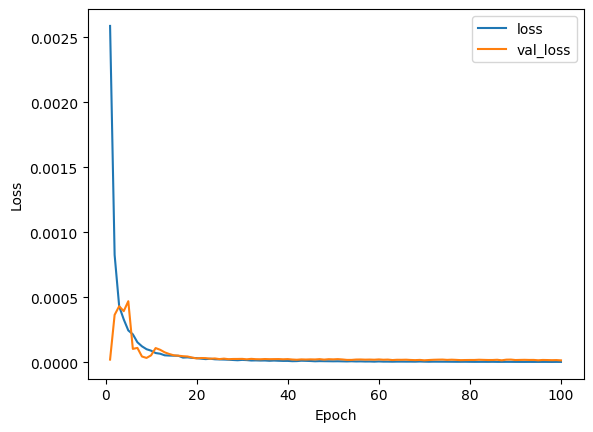

In [47]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["loss"], label="loss")
plt.plot(x, tr.history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig(os.path.join(tr.log_path, "loss.png"), bbox_inches="tight")

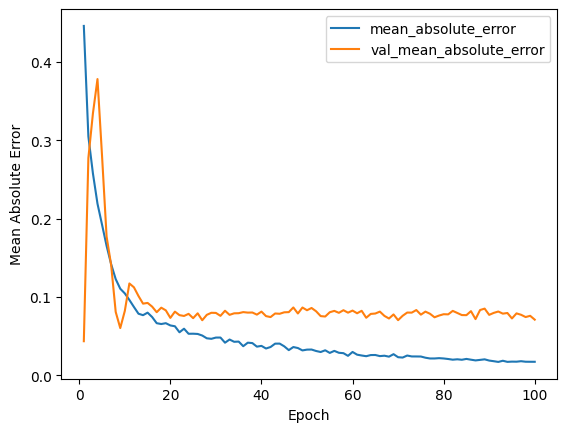

In [48]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["mean_absolute_error"], label="mean_absolute_error")
plt.plot(
    x, tr.history.history["val_mean_absolute_error"], label="val_mean_absolute_error"
)
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend(loc="upper right")
plt.savefig(os.path.join(tr.log_path, "error.png"), bbox_inches="tight")

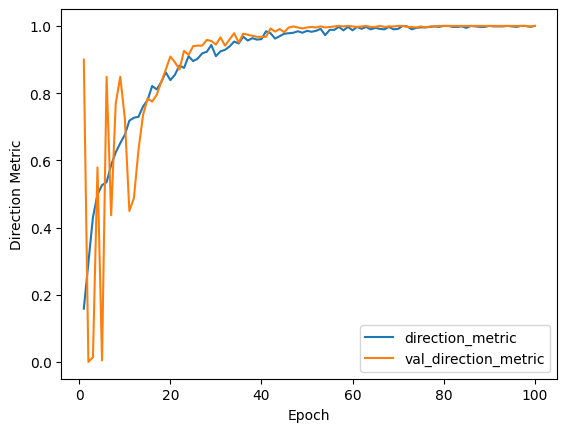

In [49]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["direction_metric"], label="direction_metric")
plt.plot(x, tr.history.history["val_direction_metric"], label="val_direction_metric")
plt.xlabel("Epoch")
plt.ylabel("Direction Metric")
plt.legend(loc="lower right")
plt.savefig(os.path.join(tr.log_path, "direction.png"), bbox_inches="tight")

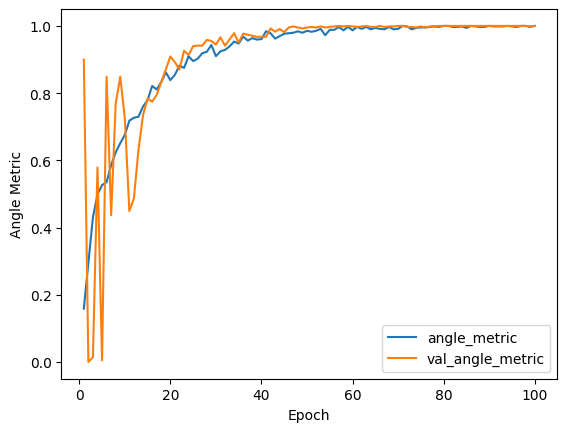

In [50]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["angle_metric"], label="angle_metric")
plt.plot(x, tr.history.history["val_angle_metric"], label="val_angle_metric")
plt.xlabel("Epoch")
plt.ylabel("Angle Metric")
plt.legend(loc="lower right")
plt.savefig(os.path.join(tr.log_path, "angle.png"), bbox_inches="tight")

### Save tf lite models for best train, best val and last checkpoint

In [51]:
best_train_checkpoint = "cp-best-train.ckpt"
best_train_tflite = utils.generate_tflite(tr.checkpoint_path, best_train_checkpoint)
utils.save_tflite(best_train_tflite, tr.checkpoint_path, "best-train")
best_train_index = np.argmin(np.array(tr.history.history["loss"]))
print(
    "Best Train Checkpoint (epoch %s) - angle: %.4f, val_angle: %.4f, direction: %.4f, val_direction: %.4f"
    % (
        best_train_index,
        tr.history.history["angle_metric"][best_train_index],
        tr.history.history["val_angle_metric"][best_train_index],
        tr.history.history["direction_metric"][best_train_index],
        tr.history.history["val_direction_metric"][best_train_index],
    )
)

Best Train Checkpoint (epoch 97) - angle: 1.0000, val_angle: 1.0000, direction: 1.0000, val_direction: 1.0000


In [52]:
best_val_checkpoint = "cp-best-val.ckpt"
best_val_tflite = utils.generate_tflite(tr.checkpoint_path, best_val_checkpoint)
utils.save_tflite(best_val_tflite, tr.checkpoint_path, "best")
utils.save_tflite(best_val_tflite, tr.checkpoint_path, "best-val")
best_val_index = np.argmin(np.array(tr.history.history["val_loss"]))
print(
    "Best Val Checkpoint (epoch %s) - angle: %.4f, val_angle: %.4f, direction: %.4f, val_direction: %.4f"
    % (
        best_val_index,
        tr.history.history["angle_metric"][best_val_index],
        tr.history.history["val_angle_metric"][best_val_index],
        tr.history.history["direction_metric"][best_val_index],
        tr.history.history["val_direction_metric"][best_val_index],
    )
)

Best Val Checkpoint (epoch 99) - angle: 1.0000, val_angle: 1.0000, direction: 1.0000, val_direction: 1.0000


In [53]:
last_checkpoint = "cp-last.ckpt"
last_tflite = utils.generate_tflite(tr.checkpoint_path, last_checkpoint)
utils.save_tflite(last_tflite, tr.checkpoint_path, "last")
print(
    "Last Checkpoint - angle: %.4f, val_angle: %.4f, direction: %.4f, val_direction: %.4f"
    % (
        tr.history.history["angle_metric"][-1],
        tr.history.history["val_angle_metric"][-1],
        tr.history.history["direction_metric"][-1],
        tr.history.history["val_direction_metric"][-1],
    )
)

Last Checkpoint - angle: 1.0000, val_angle: 1.0000, direction: 1.0000, val_direction: 1.0000


### Evaluate the best model (train loss) on the training set

In [54]:
best_train_model = utils.load_model(
    os.path.join(tr.checkpoint_path, best_train_checkpoint),
    tr.loss_fn,
    tr.metric_list,
    tr.custom_objects,
)
loss, mae, direction, angle = best_train_model.evaluate(
    tr.train_ds,
    steps=tr.image_count_train / tr.hyperparameters.TRAIN_BATCH_SIZE,
    verbose=1,
)

42/42 [==============================] - 1s 11ms/step - loss: 1.1699e-06 - mean_absolute_error: 0.0146 - direction_metric: 1.0000 - angle_metric: 1.0000


1/1 [==============================] - 0s 110ms/step


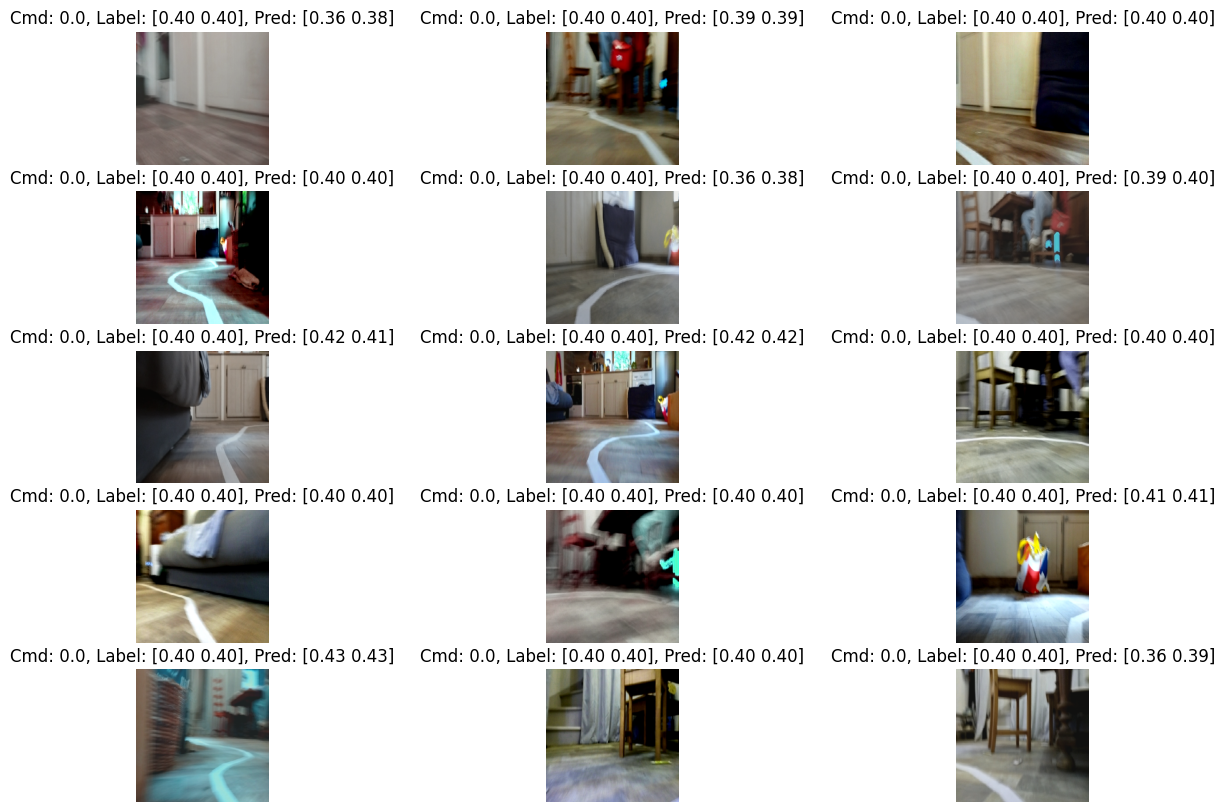

In [55]:
utils.show_batch(
    dataset=tr.train_ds, policy=tr.hyperparameters.POLICY, model=best_train_model
)

In [56]:
utils.compare_tf_tflite(best_train_model, best_train_tflite)

1/1 [==============================] - 0s 102ms/step
tflite: [[0.37945172 0.3614736 ]]
tf: [[0.38080674 0.3628298 ]]
Almost equal (10% tolerance): True


### Evaluate the best model (val loss) on the validation set

In [57]:
best_val_model = utils.load_model(
    os.path.join(tr.checkpoint_path, best_val_checkpoint),
    tr.loss_fn,
    tr.metric_list,
    tr.custom_objects,
)
loss, mae, direction, angle = best_val_model.evaluate(
    tr.test_ds,
    steps=tr.image_count_test / tr.hyperparameters.TEST_BATCH_SIZE,
    verbose=1,
)

24/24 [==============================] - 0s 9ms/step - loss: 1.3491e-05 - mean_absolute_error: 0.0707 - direction_metric: 1.0000 - angle_metric: 1.0000


1/1 [==============================] - 0s 108ms/step


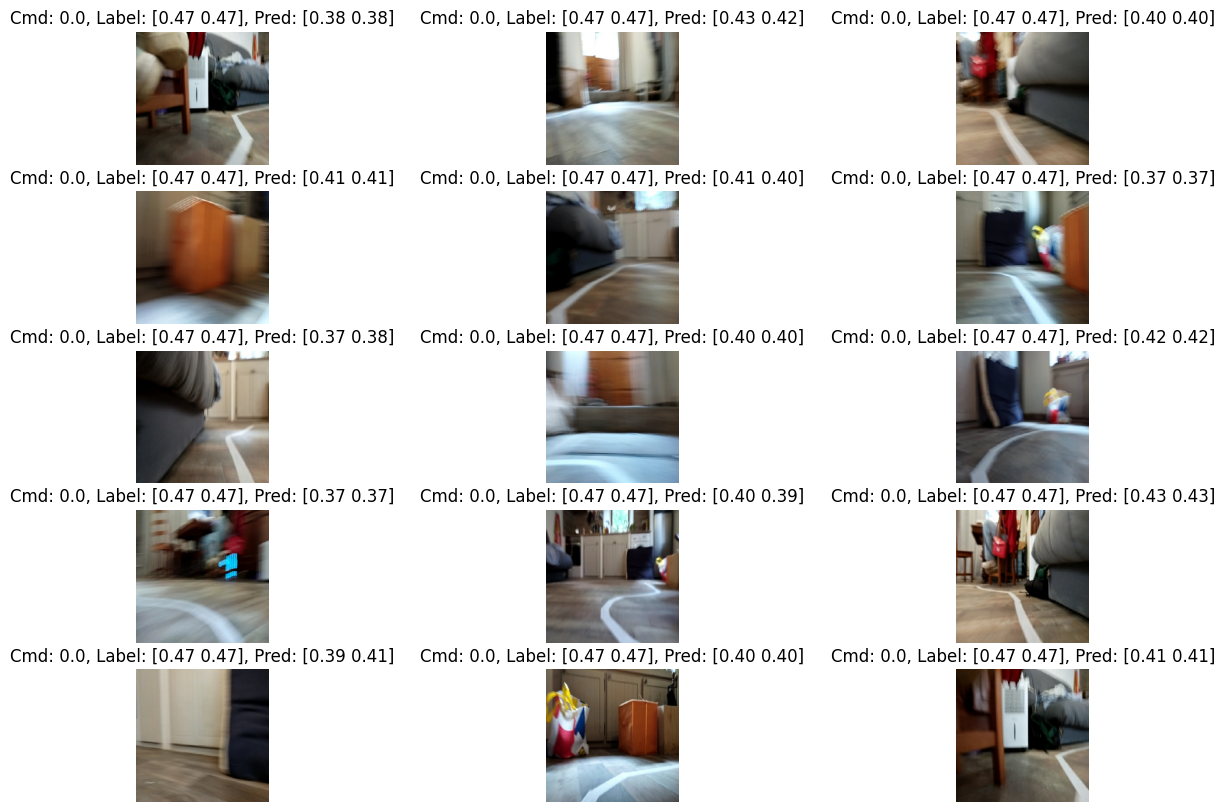

In [58]:
utils.show_batch(
    dataset=tr.test_ds, policy=tr.hyperparameters.POLICY, model=best_val_model
)

In [59]:
utils.compare_tf_tflite(best_val_model, best_val_tflite)

1/1 [==============================] - 0s 103ms/step
tflite: [[0.40382826 0.37318882]]
tf: [[0.40302014 0.3722108 ]]
Almost equal (10% tolerance): True


## Save the notebook as HTML

In [60]:
utils.save_notebook()
current_file = "policy_learning.ipynb"
output_file = os.path.join(tr.log_path, "notebook.html")
utils.output_HTML(current_file, output_file)